In [ ]:
import keras
keras.__version__

import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

#!pip install transformers

# Part 1. SotA NLP with BERT

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), etc.

This demonstration uses SQuAD (Stanford Question-Answering Dataset). In SQuAD, an input consists of a question, and a paragraph for context. The goal is to find the span of text in the paragraph that answers the question. We evaluate our performance on this data with the "Exact Match" metric, which measures the percentage of predictions that exactly match any one of the ground-truth answers.

We fine-tune a BERT model to perform this task as follows:

1. Feed the context and the question as inputs to BERT.
1. Take two vectors S and T with dimensions equal to that of hidden states in BERT.
1. Compute the probability of each token being the start and end of the answer span. The probability of a token being the start of the answer is given by a dot product between S and the representation of the token in the last layer of BERT, followed by a softmax over all tokens. The probability of a token being the end of the answer is computed similarly with the vector T.
1. Fine-tune BERT and learn S and T along the way.

Copied entirely from https://keras.io/examples/nlp/text_extraction_with_bert/


Summary about BERT available here: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

In [ ]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig


max_len = 384 # length of the input sequence
configuration = BertConfig()  # default parameters and configuration for BERT


## Set up BERT tokenizer

The tokenizer's job is to break words down into smaller chunks (aka tokens). This helps to achieve 2 things: 

1. Maintain a reasonable vocabulary size.
2. Rare words can be broken down into constituent parts so no word is out-of-vocabulary (OOV).

Each token then gets its own embedding.

**NOTE:** A word embedding is a learned representation for text where words that have the same meaning have a similar representation. It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems.

See illustration below:

In [ ]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

## Load the data



In [ ]:
train_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

## Preprocess the data

1. Go through the JSON file and store every record as a SquadExample object.
2. Go through each SquadExample and create x_train, y_train, x_eval, y_eval.

In [ ]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text, all_answers):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())
        #print("\ncontext: ", context, "\nquestion:", question, "\nanswer", answer)

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets


with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)


def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                all_answers = [_["text"] for _ in qa["answers"]]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text, all_answers
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y


train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_eval))
print(len(y_eval))

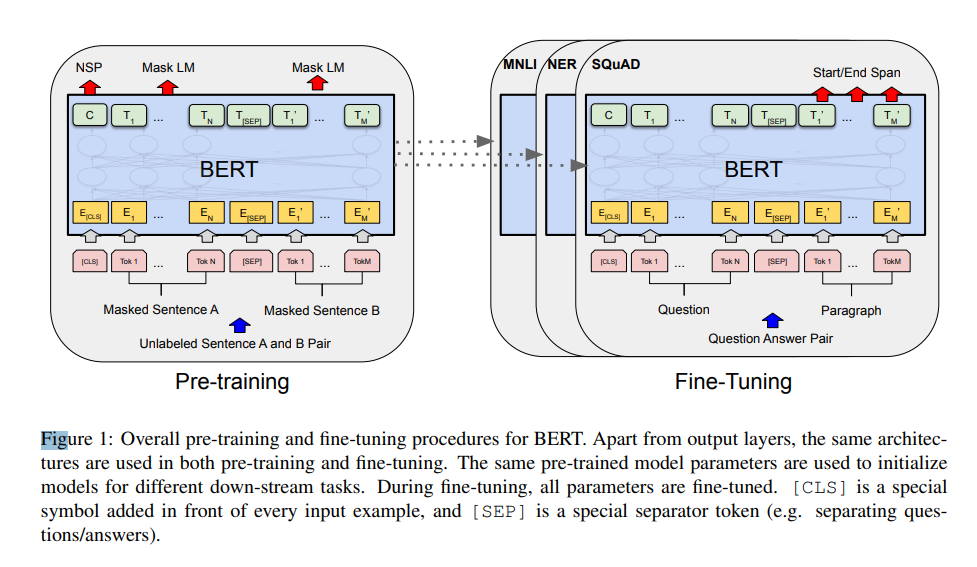



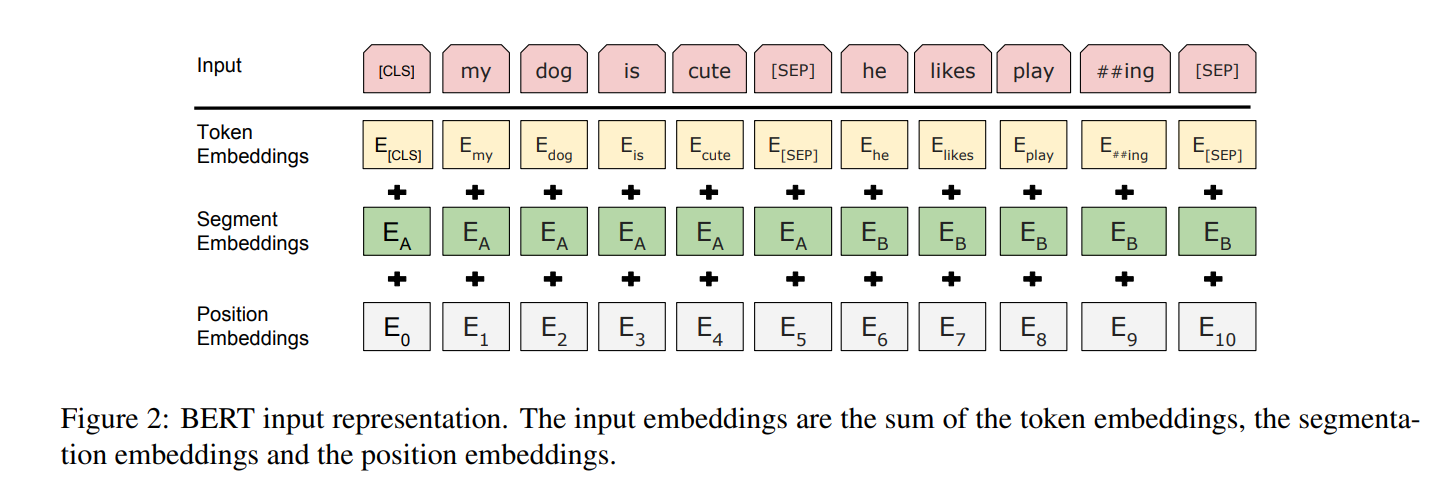

## Create the Question-Answering Model using BERT and Functional API

In [ ]:
def create_model():
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## QA Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]

    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
    end_logits = layers.Flatten()(end_logits)

    start_probs = layers.Activation(keras.activations.softmax)(start_logits)
    end_probs = layers.Activation(keras.activations.softmax)(end_logits)

    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[start_probs, end_probs],
    )
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss=[loss, loss])
    return model

The following code should preferably be run on Google Colab TPU runtime. With Colab TPUs, each epoch will take 5-6 minutes.

In [ ]:
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()

model.summary()

## Create Evaluation Callback
This callback will compute the exact match score using the validation data after every epoch.

In [ ]:
def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text


class ExactMatch(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)
            normalized_true_ans = [normalize_text(_) for _ in squad_eg.all_answers]
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

# train and evaluate

In [ ]:
exact_match_callback = ExactMatch(x_eval, y_eval)
model.fit(
    x_train,
    y_train,
    epochs=1,  # For demonstration, 3 epochs are recommended
    verbose=2,
    batch_size=64,
    callbacks=[exact_match_callback],
)

# Prediction example

In [ ]:
pred_start, pred_end = model.predict(x_eval)
count = 0
eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
  squad_eg = eval_examples_no_skip[idx]
  offsets = squad_eg.context_token_to_char
  start = np.argmax(start)
  end = np.argmax(end)
  if start >= len(offsets):
      continue
  pred_char_start = offsets[start][0]
  if end < len(offsets):
      pred_char_end = offsets[end][1]
      pred_ans = squad_eg.context[pred_char_start:pred_char_end]
  else:
      pred_ans = squad_eg.context[pred_char_start:]

  normalized_pred_ans = normalize_text(pred_ans)
  normalized_true_ans = [normalize_text(_) for _ in squad_eg.all_answers]

In [ ]:
squad_eg.question

In [ ]:
squad_eg.context

In [ ]:
normalized_pred_ans

In [ ]:
normalized_true_ans

# Part 2. Introduction to generative adversarial networks (GANs)



This notebook contains the second code sample found in Chapter 12, Section 5 of Deep Learning with Python, Second Edition. Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

*Generative Adversarial Networks (GANs)* are a type of machine learning algorithm that can generate new data samples that are similar to a given dataset. They enable the generation of fairly realistic synthetic images by forcing the generated images to be statistically
almost indistinguishable from real ones. A GAN is made of two parts: a *generator* and a *discriminator*.

- *Generator network* — The generator network is responsible for generating new data samples, i.e., takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image.
-*Discriminator network (or adversary)* — Takes as input an image (real or synthetic), and predicts whether the image came from the training set (i.e., real data samples) or was created by the generator network.

The *generator network* is trained to be able to fool the *discriminator network*, and thus it evolves toward generating increasingly realistic images as training goes on.




## A schematic GAN implementation


In what follows, we explain how to implement a GAN in Keras, in its barest form -- since GANs are quite advanced, diving deeply into the 
technical details would be out of scope for us. Our specific implementation will be a deep convolutional GAN, or DCGAN: a GAN where the 
generator and discriminator are deep convnets. In particular, it leverages a `Conv2DTranspose` layer for image upsampling in the generator.

We’ll train our GAN on images from the Large-scale CelebFaces Attributes dataset (known as CelebA), a dataset of 200,000 faces of celebrities (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) To speed up training, we’ll resize the images to 64 × 64, so we’ll be learning to generate 64 × 64 images of human faces. Schematically, the GAN looks like this:


- A `generator network` maps vectors of shape `(latent_dim,)` to images of shape `(64, 64, 3)`. 
- A `discriminator network` maps images of shape `(64, 64, 3)` to a *binary score* estimating the probability that the image is real.
- A `GAN network` chains the generator and the discriminator together: `gan(x) =
discriminator(generator(x))`. Thus, this `GAN network` maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as *decoded* by the generator.
- We train the discriminator using examples of real and fake images along with “real”/“fake” labels, just as we train any regular image-classification model. 
- To train the generator, we use the gradients of the generator’s weights with regard to the loss of the `GAN model`. This means that at every step, we move the
weights of the generator in a direction that makes the discriminator more likely to classify as “real” the images decoded by the generator. In other words, we
train the generator to fool the discriminator.


More Details...

Here's an example of a simple GAN network architecture:

**Generator Network:**
The generator network takes a random input noise vector and generates a new data sample. The generator typically consists of one or more fully connected or convolutional layers, followed by a final activation function (such as tanh or sigmoid) to ensure that the output values are within a certain range. The architecture of the generator can vary depending on the type of data being generated.

**Discriminator Network:**
The discriminator network takes in a data sample and classifies it as real or fake. The discriminator typically consists of one or more fully connected or convolutional layers, followed by a final sigmoid activation function to produce a probability value between 0 and 1.

**Loss Function:**
The loss function for the GAN is typically a combination of the generator and discriminator losses. The generator loss encourages the generator to generate data samples that the discriminator is likely to classify as real, while the discriminator loss encourages the discriminator to correctly classify real and generated data samples.

**Training:**
During training, the generator and discriminator are trained in alternating steps. In each step, the generator generates a new data sample and the discriminator classifies it as real or fake. The generator and discriminator losses are then used to update the weights of the corresponding networks.

Here's a simplified diagram of the GAN architecture:

Random noise -> Generator -> Generated Data

Real Data -> Discriminator -> Real/Fake Classification

During training, the generator and discriminator networks are updated in alternating steps until the generator can produce new data samples that are indistinguishable from the real data by the discriminator.

## A bag of tricks


Training GANs and tuning GAN implementations is notoriously difficult. There are a number of known "tricks" that one should keep in mind. 
Like most things in deep learning, it is more alchemy than science: these tricks are really just heuristics, not theory-backed guidelines. 
They are backed by some level of intuitive understanding of the phenomenon at hand, and they are known to work well empirically, albeit not 
necessarily in every context.

Here are a few of the tricks that we leverage in our own implementation of a GAN generator and discriminator below. It is not an exhaustive 
list of GAN-related tricks; you will find many more across the GAN literature.

- We use *strides* instead of *pooling* for downsampling feature maps in the `discriminator`.
- We sample points from the latent space using a `normal distribution (Gaussian distribution)`, not a `uniform distribution`.
- Stochasticity is good for inducing robustness. Because GAN training results in a *dynamic equilibrium*, GANs are likely to get stuck in all sorts of ways. Introducing
randomness during training helps prevent this. *We introduce randomness by adding random noise to the labels for the discriminator.*
- Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. *Two things can induce gradient sparsity: max pooling operations and relu activations*. Instead of max pooling, we recommend using strided convolutions for downsampling, and we recommend using a `LeakyReLU layer` instead of a `relu activation`. It’s similar to
relu, but it relaxes sparsity constraints by allowing small negative activation values.
- In generated images, it’s common to see `checkerboard artifacts` caused by unequal coverage of the pixel space in the `generator` (see figure 12.21). To fix this, we *use a kernel size that’s divisible by the stride size* whenever we use a `strided Conv2DTranspose` or `Conv2D` in both the `generator` and the `discriminator`.

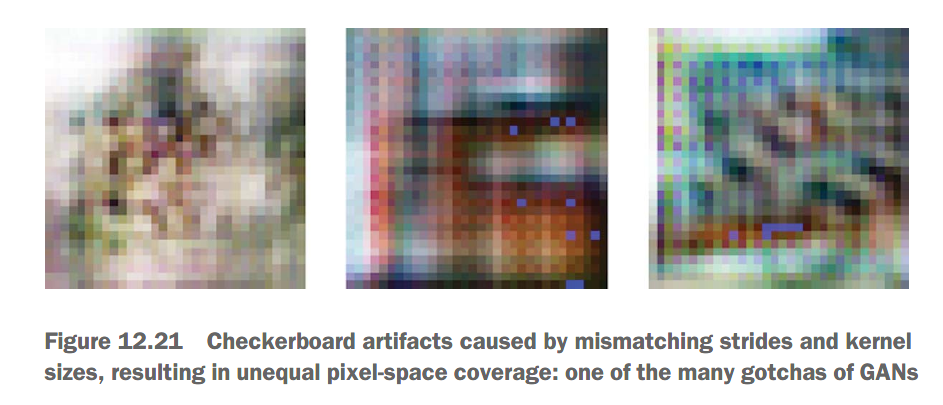

To download the data, run the following from Google Drive and uncompress it.


In [1]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Load google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Check whether gdown is installed
!pip list -v | grep gdown

gdown                         4.4.0        /usr/local/lib/python3.9/dist-packages pip


In [ ]:
# Create a working directory for CelebA data
#!mkdir celeba_gan

In [28]:
# Download the compressed data using gdown (available by default in Colab; install it otherwise).
#!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip

# Or else:

!gdown --id 0B7EVK8r0v71pZjFTYXZWM3FlRnM


/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM 



Download the dataset by clicking on the link and upload to a suitable folder on your Google drive. The next step is to copy the dataset from Google drive to Colab.

In [ ]:
# Copy celebA dataset from Google drive to colab
#!cp -rv /content/drive/MyDrive/Colab\ Notebooks/IM931-2023/img_align_celeba.zip /content/celeba_gan/
!cp -rv /content/drive/MyDrive/Colab\ Notebooks/IM931-2023/img_align_celeba.zip /content


In [ ]:
# Uncompress the data.
#!unzip -qq celeba_gan/img_align_celeba.zip -d celeba_gan
!unzip -qq img_align_celeba.zip   #-d celeba_gan

In [3]:
data_dir = '/content/img_align_celeba/'

# sanity check to see that all the files have loaded correctly 
print('Total images:', len(os.listdir(data_dir)))

Total images: 202599


In [ ]:
# Optionally remove compressed file to save disk space
!rm celeba_gan/img_align_celeba.zip

Once you’ve got the uncompressed images in the `celeba_gan` directory, you can use `image_dataset_from_directory` to turn it into a dataset. Since we just need the images—there are no labels—we’ll specify `label_mode=None`.

In [4]:
# Creating a dataset from a directory of images
from tensorflow import keras

dataset = keras.utils.image_dataset_from_directory(
    "img_align_celeba",
    label_mode=None,       #only the images will be returned—no labels.
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)   

Found 202599 files belonging to 1 classes.


`smart_resize=True` resizes images to `64×64` using a smart combination of cropping and resizing to preserve aspect ratio. We don’t want face proportions to get distorted!

Finally, let’s rescale the images to the [0-1] range.



In [5]:
dataset = dataset.map(lambda x: x / 255.)  #Lambda functions will soon be deprecated

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
print(len(dataset))

6332


In [ ]:
# Alternate code for rescaling images between 0 and 1
from tensorflow.image import resize

# Define rescaling function  
def preprocess_image(image):
    # Rescale pixel values to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    # Scale to [0, 1]
    image = (image + 1) / 2
    return image

# Apply rescaling function to each batch of images
dataset = dataset.map(preprocess_image)


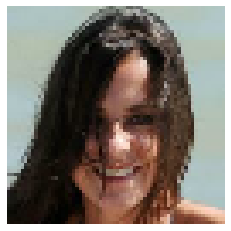

In [7]:
# Displaying the first image
import matplotlib.pyplot as plt

for x in dataset:
  plt.axis("off")
  plt.imshow((x.numpy() * 255).astype("int32")[0])
  break

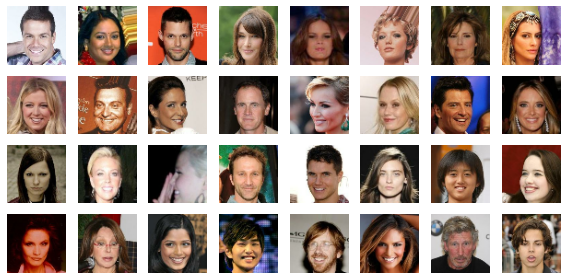

In [8]:
# Get a batch of images from the dataset
image_batch = next(iter(dataset))

# Plot the images in a grid
fig, axs = plt.subplots(4, 8, figsize=(8, 4), sharey=True, sharex=True)
axs = axs.flatten()
for img, ax in zip(image_batch, axs):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


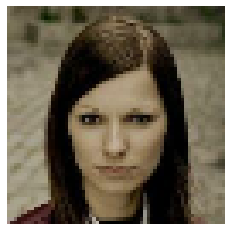

In [9]:
# To select a single image from the batch
image = image_batch[16]

# Plot the image
plt.imshow(image)
plt.axis('off');

In [10]:
for data in dataset:
  print("dataset shape:", data.shape)
  #print("labels batch shape:", labels_batch.shape)
  break

dataset shape: (32, 64, 64, 3)


## The Discriminator
First, we’ll develop a discriminator model that takes as input a candidate image (real or synthetic) and classifies it into one of two classes: “generated image” or “real image that comes from the training set.” **One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like noise.** A possible solution is to use dropout in the discriminator, so that’s what we will do here.**This is a binary classification problem.**

*Inputs*: Image with three color channel and 64×64 pixels in size.
*Outputs:* Binary classification, likelihood the sample is real (or fake).


In [11]:
# The GAN discriminator network
from tensorflow.keras import layers

discriminator = keras.Sequential(
[
    keras.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),      #one dropout layer:an important trick!
    layers.Dense(1, activation="sigmoid"),
 ],
 name="discriminator",
 )

In [12]:
# Print the discriminator model summary
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

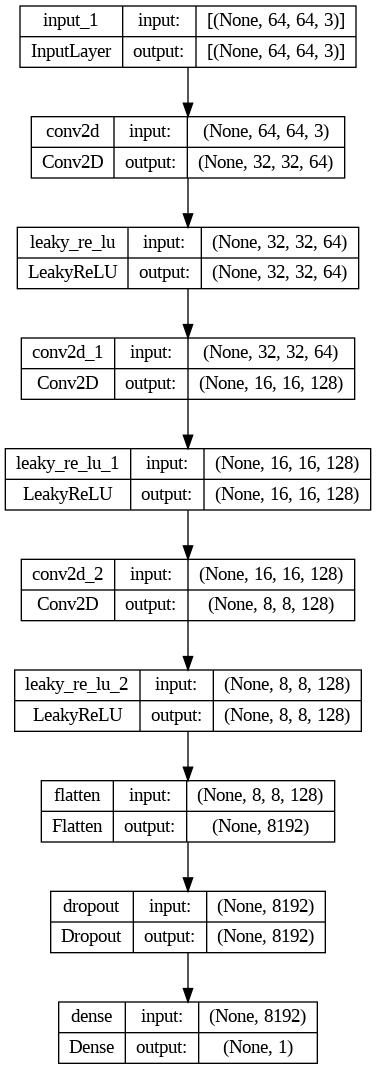

In [13]:
# plot the model
from keras.utils.vis_utils import plot_model
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## The generator


Next, let’s develop a generator model that turns a vector (from the latent space — during training it will be sampled at random) into a candidate image. 


In [14]:
# GAN generator network
latent_dim = 128    #The latent space will be made of 128-dimensional vectors.

generator = keras.Sequential(
    [
      keras.Input(shape=(latent_dim,)),
      
      # Produce the same number of coefficients we had at 
      #the level of the Flatten layer in the encoder.
      layers.Dense(8 * 8 * 128),  

      # Revert the Flatten layer of the encoder.
      layers.Reshape((8, 8, 128)),
     
      # Revert the Conv2D layers of the encoder.
      # We use LeakyReLU as our activation.
      layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
      layers.LeakyReLU(alpha=0.2),
      layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
      layers.LeakyReLU(alpha=0.2),
      layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
      layers.LeakyReLU(alpha=0.2),
     
      # The output ends up with shape (28, 28, 1).
      layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
     ],
     name="generator",
)


In [15]:
# Print generator model summary:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

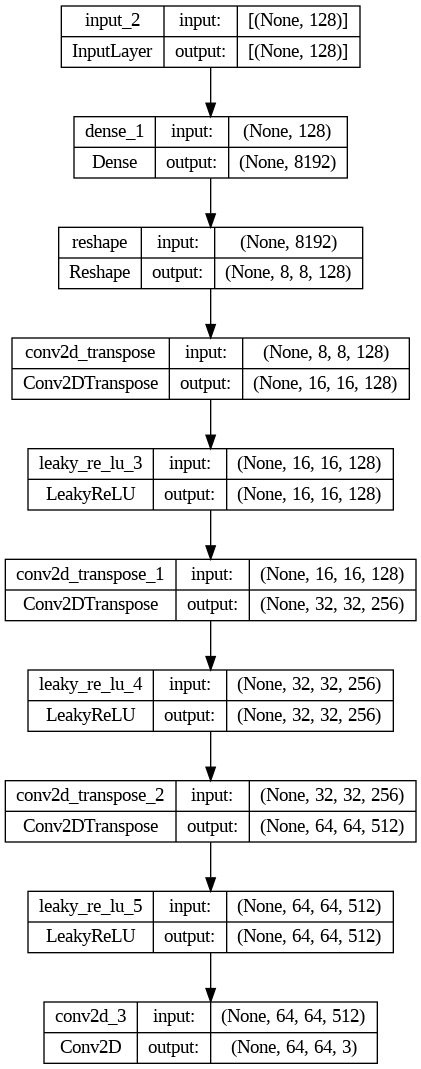

In [16]:
# plot the model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## The Adversarial Network
Finally, we’ll set up the `GAN`, which chains the generator and the discriminator. When trained, this model will move the generator in a direction that improves its
ability to fool the discriminator. This model turns latent-space points into a classification decision — “fake” or “real” — and it’s meant to be trained with labels that are always “these are real images.” So training gan will update the weights of generator in a way that makes discriminator more likely to predict “real” when looking at fake images.

To recapitulate, this is what the training loop looks like schematically. For each epoch, you do the following:
1. Draw random points in the latent space (random noise).
2. Generate images with generator using this random noise.
3. Mix the generated images with real ones.
4. Train discriminator using these mixed images, with corresponding targets: either “real” (for the real images) or “fake” (for the generated images).
5. Draw new random points in the latent space.
6. Train generator using these random vectors, with targets that all say “these are real images.” This updates the weights of the generator to move them toward
getting the discriminator to predict “these are real images” for generated images: this trains the generator to fool the discriminator.

We’ll use a `Model subclass` with a custom `train_step()`. **Note** that we’ll also use two optimizers (one for the generator, and one for the discriminator), so we will also override `compile()` to allow for passing two optimizers.




In [17]:
# The GAN Model
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

    #Sets up metrics to track the two losses over each training epoch
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    
    #Samples random points in the latent space
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(
    shape=(batch_size, self.latent_dim))

    #Decodes them to fake images
    generated_images = self.generator(random_latent_vectors)

    #Combines them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    #Assembles labels, discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
        axis=0
        )
    
    #Adds random noise to the labels — an important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
    #Trains the discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
        )
      
    #Samples random points in the latent space
    random_latent_vectors = tf.random.normal(
        shape=(batch_size, self.latent_dim))
    
    #Assembles labels that say “these are all real images” (it’s a lie!)
    misleading_labels = tf.zeros((batch_size, 1))
      
    #Trains the generator  
    with tf.GradientTape() as tape:
      predictions = self.discriminator(
          self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(grads, self.generator.trainable_weights))
    
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {"d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()}

We will now set up a callback to monitor our results before we start training: it will use the generator to create and save a number of fake images at the end of each epoch.

In [18]:
# A callback that samples generated images during training

class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(
        shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    
    for i in range(self.num_img):
      img = keras.utils.array_to_img(generated_images[i])
      img.save(f"generated_img_{epoch:03d}_{i}.png")

we can now start training the GAN.



In [19]:
# Compiling and training the GAN:
#epochs = 100   #you’ll start getting interesting results after epoch 20.
epochs = 1   

gan = GAN(discriminator=discriminator, 
          generator=generator,
          latent_dim=latent_dim)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
    )

gan.fit(
    dataset, epochs=epochs,
    callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    )


  73/6332 [..............................] - ETA: 6:05:06 - d_loss: 0.4739 - g_loss: 0.9344

KeyboardInterrupt: ignored

When training, you may see the adversarial loss begin to increase considerably, while the discriminative loss tends to zero — the discriminator may end up dominating the generator. If that’s the case, try reducing the *discriminator learning rate*, and increase the *dropout rate* of the discriminator.


Let's display a few of our fake images:

In [ ]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

**Wrapping up**
- A GAN consists of a generator network coupled with a discriminator network. The discriminator is trained to differentiate between the output of the generator and real images from a training dataset, and the generator is trained to fool the discriminator. Remarkably, the generator never sees images from the training set directly; the information it has about the data comes from the discriminator.
- GANs are difficult to train, because training a GAN is a dynamic process rather than a simple gradient descent process with a fixed loss landscape. Getting a GAN to train correctly requires using a number of heuristic tricks, as well as extensive tuning. 
- GANs can potentially produce highly realistic images. But unlike VAEs, the latent space they learn doesn’t have a neat continuous structure and thus may not be suited for certain practical applications, such as image editing via latentspace
concept vectors.

These few techniques cover only the basics of this fast-expanding field. There’s a lot more to discover out there.


